https://github.com/snazrul1/PyRevolution/blob/master/Puzzles/DSP_For_Stock_Prices.ipynb

https://tngd4ryl.medium.com/quantamental-approach-to-stock-trading-using-the-fourier-analysis-58f64792290

In [185]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from pykalman import KalmanFilter

In [186]:
data = yf.download('^GSPC',start="2019-05-01", end="2021-03-25",interval='1h')
data = data['Adj Close']
data.sort_index(ascending=True,inplace=True)
data = data.to_frame()
print(data.shape)
df = data[:3000] # for training
df

[*********************100%***********************]  1 of 1 completed
(3338, 1)


,Adj Close
2019-04-30 11:30:00-04:00,2937.500000
2019-04-30 12:30:00-04:00,2937.929932
2019-04-30 13:30:00-04:00,2943.120117
2019-04-30 14:30:00-04:00,2941.790039
2019-04-30 15:30:00-04:00,2945.370117
...,...
2021-01-12 11:30:00-05:00,3787.320068
2021-01-12 12:30:00-05:00,3797.719971
2021-01-12 13:30:00-05:00,3800.379883
2021-01-12 14:30:00-05:00,3800.570068


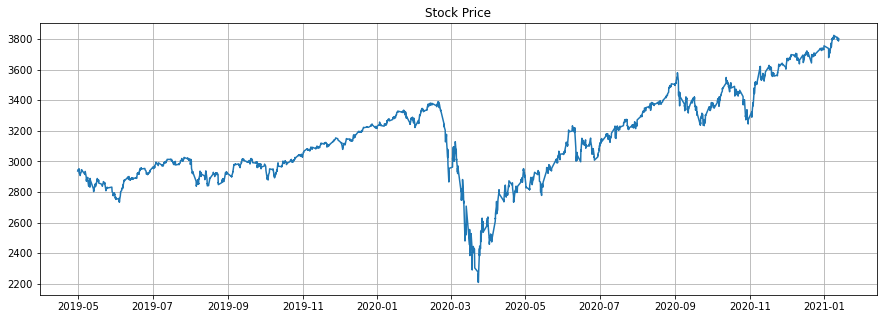

In [187]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.grid()
plt.title('Stock Price');

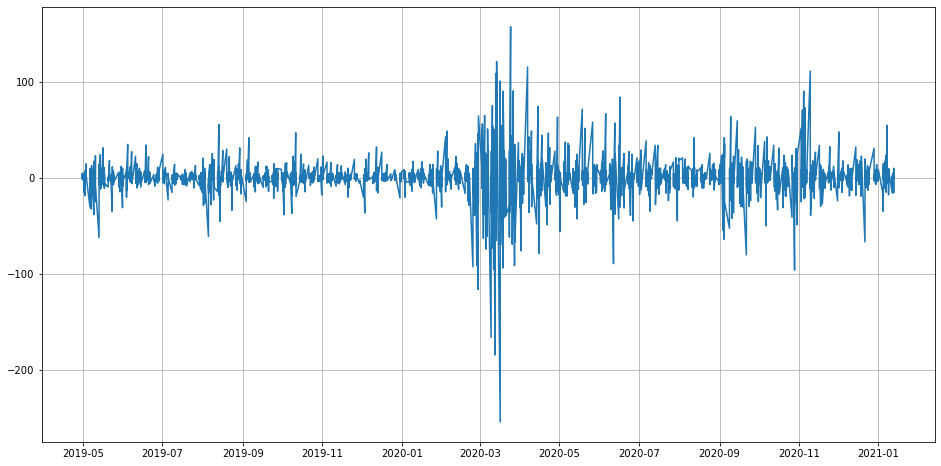

In [188]:
# calculate return
if 'return' not in df:
    df['return'] = df['Adj Close'].diff()
    # cannot use np.log diff or pct_change() here for FFT because this is measuring the delta of stock price
    df = df[1:]
    
plt.figure(figsize=(16,8))
plt.plot(df['return'])
plt.grid()

In [189]:
# calculate FFT superposition values which outputs imaginary and real number
# this is done on simple returns which resembles white noise

sp = np.fft.fft(df['return'].values)
sp[:10]

array([  863.79003906+8.52651283e-14j,   412.77266469+4.38248091e+02j,
        -699.08198888-1.24841768e+02j,  1109.34198885+4.82961903e+02j,
       -1013.0842958 -2.22842535e+02j,   517.7482854 +5.23597721e+02j,
       -1484.41279538-4.55713647e+02j,   721.31728706+1.85870320e+02j,
        -915.78486582+3.32143858e+01j,   726.2228185 +8.91884402e+02j])

$$Amplitude = \sqrt{real^2+imaginary^2}$$  
$$\tan\theta = \frac{imaginary}{real}$$

In [190]:
df['theta'] = np.arctan(sp.imag/sp.real) # phase in polar form

df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/(len(df)/2)# we only care about positive absolute amplitude, therefore 1/2

df['freq'] = np.fft.fftfreq(sp.size) # cycles per sample spacing

df

,Adj Close,return,theta,amplitude,freq
2019-04-30 12:30:00-04:00,2937.929932,0.429932,9.871048e-17,0.576052,0.000000
2019-04-30 13:30:00-04:00,2943.120117,5.190186,8.153244e-01,0.401489,0.000333
2019-04-30 14:30:00-04:00,2941.790039,-1.330078,1.767168e-01,0.473586,0.000667
2019-04-30 15:30:00-04:00,2945.370117,3.580078,4.106119e-01,0.806878,0.001000
2019-05-01 09:30:00-04:00,2947.310059,1.939941,2.165164e-01,0.691766,0.001334
...,...,...,...,...,...
2021-01-12 11:30:00-05:00,3787.320068,-15.209961,-7.910153e-01,0.491067,-0.001667
2021-01-12 12:30:00-05:00,3797.719971,10.399902,-2.165164e-01,0.691766,-0.001334
2021-01-12 13:30:00-05:00,3800.379883,2.659912,-4.106119e-01,0.806878,-0.001000
2021-01-12 14:30:00-05:00,3800.570068,0.190186,-1.767168e-01,0.473586,-0.000667


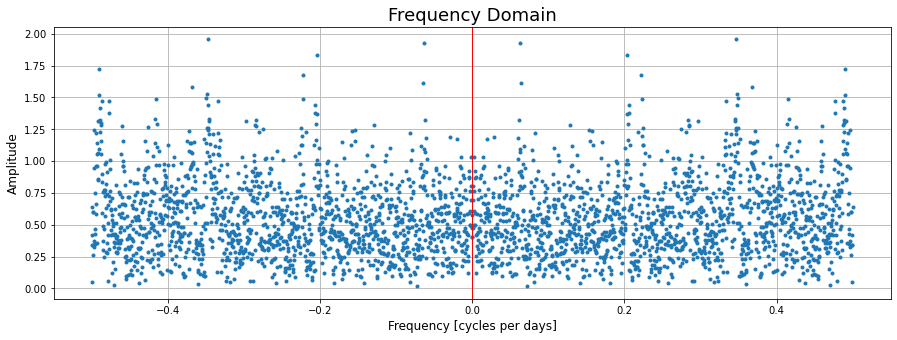

In [191]:
# The frequency and amplitude values can be used to determine the dominant frequency. 
# As we know for any Fourier Transform function, we will have a mirror image along the middle (marked in red line).

plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'], '.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency [cycles per days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

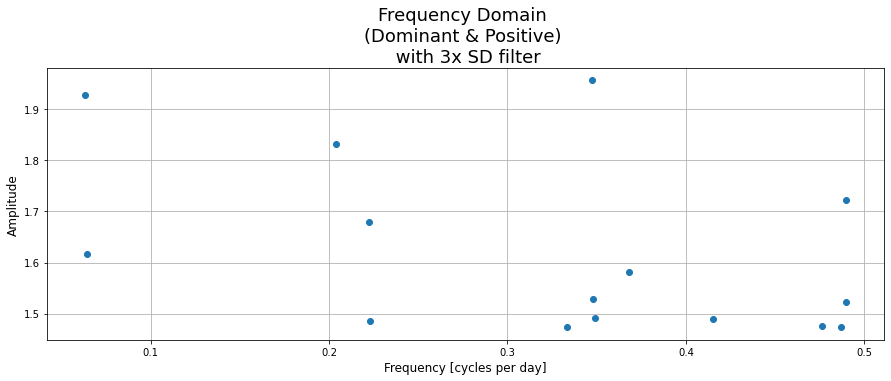

In [192]:
# For our initial analysis, we will take the left half of the mirror image (positive frequency values) 
# as well as filter out any frequency with an amplitude of over 3 standard deviations.
SDfilter = 3
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (SDfilter*stdAmp + meanAmp)
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency [cycles per day]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive) \n with {}x SD filter'.format(SDfilter), fontsize=18)
plt.grid();

### inverse fourier transform to time domain

$\nu=\frac{1}{T}$ = frequency denoted by greek letter nu
$$f(t)=\Sigma_{v=-\inf}^{\inf}{A(\nu)*\cos({2\pi \nu t}})$$

In [193]:
# Using the dominant frequency values, we can attempt to reconstruct the stock prices. Since we have been using the time delta, 
# we will perform a cumsum on all the time deltas and add it to the initial adjusting closing stock value to perform a regression.

regressionDelta = 0

for n in range(len(dominantTheta)):
    #print(str(n)+'th--------------')
    #print(dominantAmp[n])
    shift = dominantTheta[n]
    #print(shift)
    #print(np.array(range(len(df))))
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift) # adding up till len(df)
    

#Converting Delta Time to Time at start value of real data
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

df['predict_return'] = regressionDelta
df['predict_price'] = regression
df

,Adj Close,return,theta,amplitude,freq,predict_return,predict_price
2019-04-30 12:30:00-04:00,2937.929932,0.429932,9.871048e-17,0.576052,0.000000,14.990255,2952.920187
2019-04-30 13:30:00-04:00,2943.120117,5.190186,8.153244e-01,0.401489,0.000333,-2.818385,2950.101802
2019-04-30 14:30:00-04:00,2941.790039,-1.330078,1.767168e-01,0.473586,0.000667,-1.373358,2948.728444
2019-04-30 15:30:00-04:00,2945.370117,3.580078,4.106119e-01,0.806878,0.001000,-2.847737,2945.880707
2019-05-01 09:30:00-04:00,2947.310059,1.939941,2.165164e-01,0.691766,0.001334,-0.835036,2945.045671
...,...,...,...,...,...,...,...
2021-01-12 11:30:00-05:00,3787.320068,-15.209961,-7.910153e-01,0.491067,-0.001667,-0.177112,5937.308949
2021-01-12 12:30:00-05:00,3797.719971,10.399902,-2.165164e-01,0.691766,-0.001334,-5.040031,5932.268919
2021-01-12 13:30:00-05:00,3800.379883,2.659912,-4.106119e-01,0.806878,-0.001000,6.583792,5938.852710
2021-01-12 14:30:00-05:00,3800.570068,0.190186,-1.767168e-01,0.473586,-0.000667,14.216527,5953.069237


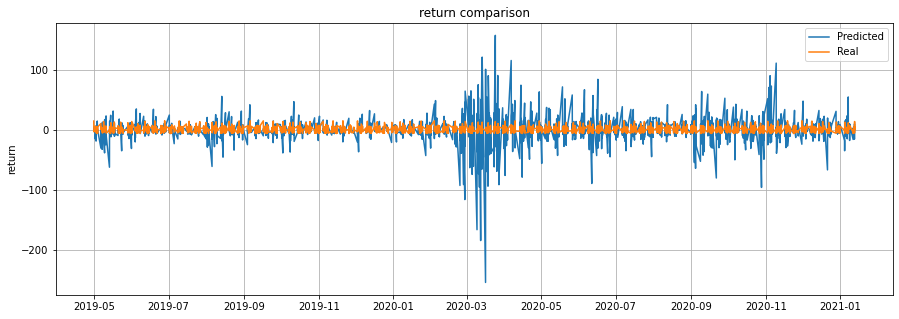

In [194]:
plt.figure(figsize=(15,5))
plt.plot(df['return'])
plt.plot(df['predict_return'])
plt.ylabel('return')
plt.legend(['Predicted','Real'])
plt.title('return comparison')
plt.grid()

1489.5685241088097

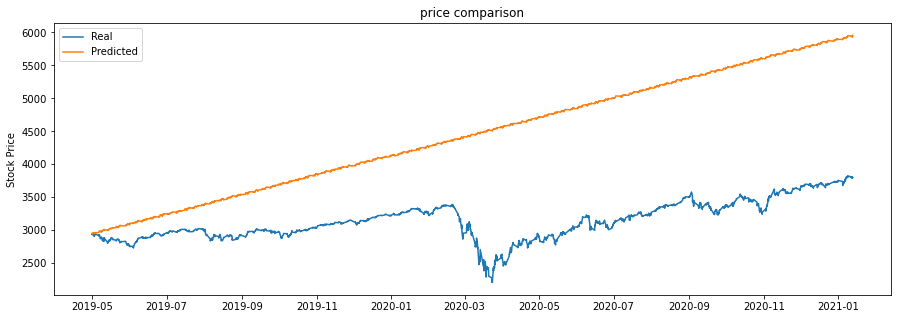

In [195]:
plt.figure(figsize=(15,5))
plt.plot(df['Adj Close'])
plt.plot(df['predict_price'])
plt.ylabel('Stock Price')
plt.legend(['Real','Predicted'])
plt.title('price comparison')

rmse = np.sqrt(np.mean((df['Adj Close'].values - df['predict_price'].values)**2))
rmse

## Optimization

Our preliminary results isn't that bad. Now we can try to optimize our filter value (the standard deviation) to minimize our RMSE.

In [196]:
def std_filter(std_value):
    
    # for the variables can be used outside function
    global regressionDelta
    global regression
    regressionDelta = 0
    regression = 0
    
    #Getting dominant values based on std_value
    meanAmp = df['amplitude'].mean()
    stdAmp = df['amplitude'].std()
    dominantAmpCheck = df['amplitude'] > (std_value*stdAmp + meanAmp)
    positiveFreqCheck = df['freq'] > 0
    dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

    #Calculating Regression Delta
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift) # adding up till len(df)

    #Converting Delta Time to Time at start value of real data
    startValue = df['Adj Close'][0]
    regression = startValue + np.cumsum(regressionDelta)

    #Calculating RMSE
    rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

    #if np.isnan(rmse) or len(regression)==1:
    if np.isnan(rmse):
        rmse = 10000000000000

    return rmse

In [197]:
std_values = []
rmse_values = []

# loop thru and try diff std filter thresholds
for i in np.linspace(0,7,100): # 100 steps, infer step size
    std_values.append(i)
    rmse_values.append(std_filter(i))

rmse_values

[1066.0462584330355,
 1266.261296184016,
 1239.9194444661048,
 1144.2074639194107,
 1241.7319551405508,
 1148.345388788978,
 1139.6089887572114,
 1035.324753499695,
 1130.2296190434668,
 1017.8174645496827,
 1050.1174557037218,
 1126.5269628821425,
 1577.2310679645043,
 1608.1606899592123,
 1458.24794534452,
 1485.9198977453254,
 1492.4620206704026,
 1539.8159267059696,
 1481.9690077869836,
 1452.016461478701,
 1487.7548517429243,
 1559.2390998906765,
 1533.0534644286422,
 1565.3948000961911,
 1564.9020065508541,
 1602.1805017375455,
 1485.3138321787806,
 1553.1980059384998,
 1587.7350721302723,
 669.775841661233,
 424.77527624447026,
 299.03462898580614,
 355.4028023775941,
 352.612613860715,
 341.6648318444029,
 356.52588516552026,
 1493.3966225237527,
 1495.1094444647604,
 1488.50155088251,
 1488.50155088251,
 1488.50155088251,
 1491.9037150975535,
 1489.5685241088097,
 1492.771809642623,
 1482.0438767216556,
 1482.1907695594653,
 1489.4217116714542,
 1489.4217116714542,
 1486.94008

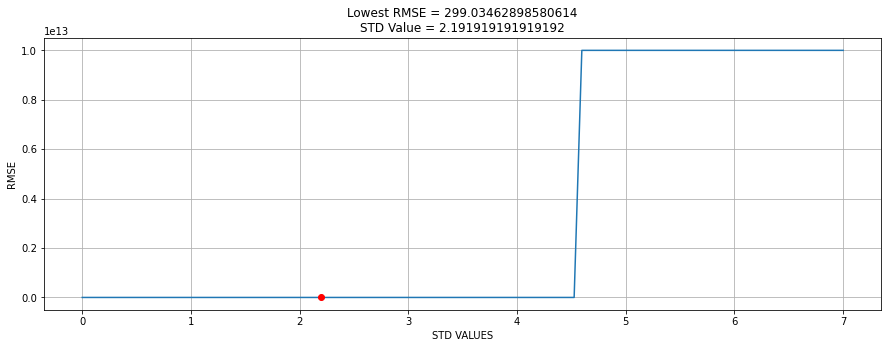

In [198]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

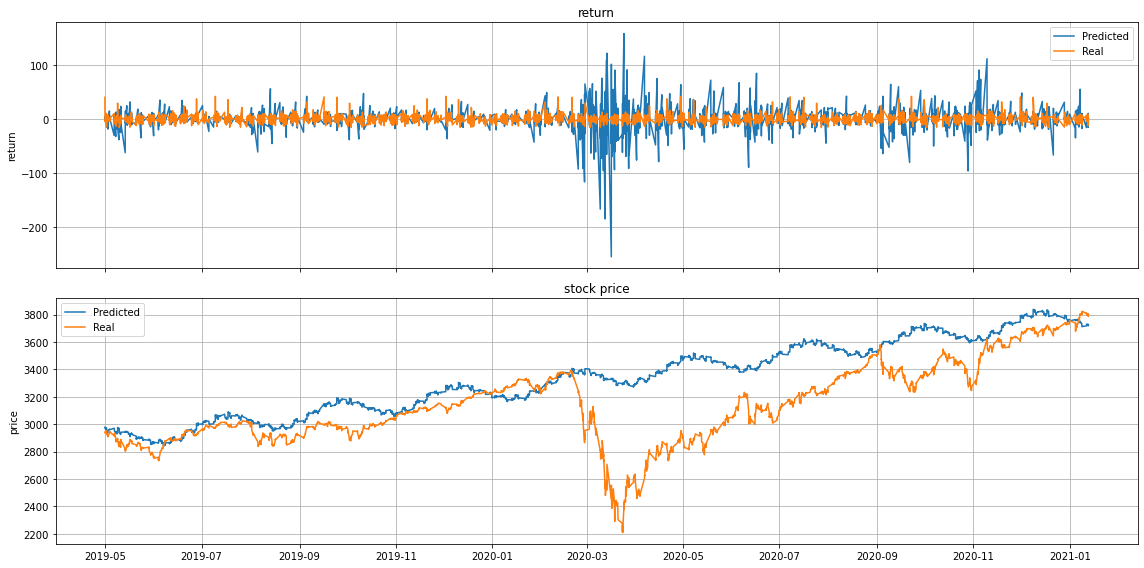

In [199]:
std_filter(minSTD)
df['predict_return'] = regressionDelta
df['predict_price'] = regression

fig , axarr = plt.subplots(2, sharex=True,figsize=(16,8))
axarr[0].plot(df['return'])
axarr[0].plot(df['predict_return'])
axarr[0].legend(['Predicted','Real'])
axarr[0].title.set_text('return')
axarr[0].set_ylabel('return')
axarr[0].grid()
axarr[1].plot(df['predict_price'])
axarr[1].plot(df['Adj Close'])
axarr[1].legend(['Predicted','Real'])
axarr[1].title.set_text('stock price')
axarr[1].set_ylabel('price')
axarr[1].grid()
plt.tight_layout();


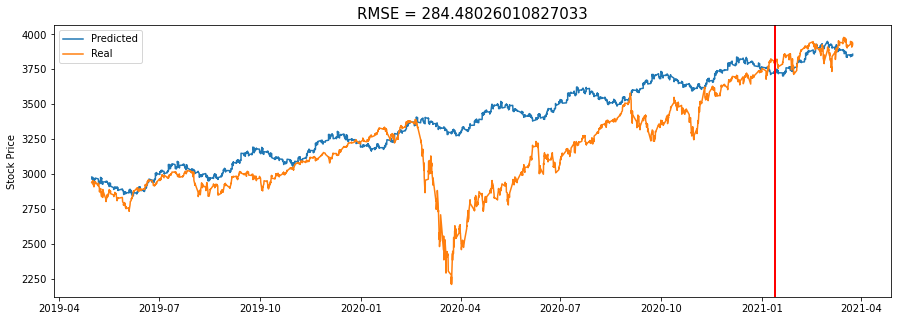

In [200]:
# Out of sample prediction

#Getting dominant values based on std_value
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (minSTD*stdAmp + meanAmp)
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(data))) + shift) # adding up till len(df)
#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

data['predict_price'] = regression

plt.figure(figsize=(15,5))
plt.plot(data['predict_price'])
plt.plot(data['Adj Close'])
plt.ylabel('Stock Price')
plt.legend(['Predicted','Real'])
plt.title('price comparison')

plt.axvline(x=dt.datetime.strptime('2021-01-13','%Y-%m-%d'), ymin=0, ymax = 1, linewidth=2, color='r')

rmse = np.sqrt(np.mean((data['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

In [201]:
df

,Adj Close,return,theta,amplitude,freq,predict_return,predict_price
2019-04-30 12:30:00-04:00,2937.929932,0.429932,9.871048e-17,0.576052,0.000000,40.284080,2978.214012
2019-04-30 13:30:00-04:00,2943.120117,5.190186,8.153244e-01,0.401489,0.000333,-2.709109,2975.504902
2019-04-30 14:30:00-04:00,2941.790039,-1.330078,1.767168e-01,0.473586,0.000667,-4.495397,2971.009506
2019-04-30 15:30:00-04:00,2945.370117,3.580078,4.106119e-01,0.806878,0.001000,-2.349737,2968.659769
2019-05-01 09:30:00-04:00,2947.310059,1.939941,2.165164e-01,0.691766,0.001334,-6.580964,2962.078804
...,...,...,...,...,...,...,...
2021-01-12 11:30:00-05:00,3787.320068,-15.209961,-7.910153e-01,0.491067,-0.001667,8.440872,3725.684271
2021-01-12 12:30:00-05:00,3797.719971,10.399902,-2.165164e-01,0.691766,-0.001334,-0.581279,3725.102993
2021-01-12 13:30:00-05:00,3800.379883,2.659912,-4.106119e-01,0.806878,-0.001000,1.856183,3726.959175
2021-01-12 14:30:00-05:00,3800.570068,0.190186,-1.767168e-01,0.473586,-0.000667,0.310996,3727.270171


In [202]:
# Construct a Kalman filter


kf = KalmanFilter(observation_matrices = [1], # this tells us the next measurement we should expect given the predicted next state
                  # or this can be random walk if modeling a fairly stable system so next move would be the same 1*
                  # observation matrix will dot with transition matrix
                  observation_covariance=1, # assume price has variance 1 under R.W model (hard to know)
                  # also this represents the error of the guesses
                  initial_state_mean = 0, # guess 0 for 1d
                  initial_state_covariance = 1, # assume price move as our model says, 1 for identity matrix. error for guess
                  transition_matrices = [1], # how state evolves (identity matrix if R.W)
                  transition_covariance=.01)# this is the kalman gain or err term for transition matrix: 
                  # (Err_state)/(Err_state+Err_measure)
                  # important to keep track this as new measurements come in, also hard to know
                  # bigger this value, more overfitting
                  # close to 1 means stock price is accurate - weigh more on recent event - overfitting
                  # close to 0 means stock price is not accurate - weigh more on historical event - fit with lag

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(df['Adj Close'].values)
# ignore cov so repalce with _
df['state_means'] = state_means
df

,Adj Close,return,theta,amplitude,freq,predict_return,predict_price,state_means
2019-04-30 12:30:00-04:00,2937.929932,0.429932,9.871048e-17,0.576052,0.000000,40.284080,2978.214012,1468.964966
2019-04-30 13:30:00-04:00,2943.120117,5.190186,8.153244e-01,0.401489,0.000333,-2.709109,2975.504902,1966.858428
2019-04-30 14:30:00-04:00,2941.790039,-1.330078,1.767168e-01,0.473586,0.000667,-4.495397,2971.009506,2218.411958
2019-04-30 15:30:00-04:00,2945.370117,3.580078,4.106119e-01,0.806878,0.001000,-2.349737,2968.659769,2372.069086
2019-05-01 09:30:00-04:00,2947.310059,1.939941,2.165164e-01,0.691766,0.001334,-6.580964,2962.078804,2476.329942
...,...,...,...,...,...,...,...,...
2021-01-12 11:30:00-05:00,3787.320068,-15.209961,-7.910153e-01,0.491067,-0.001667,8.440872,3725.684271,3798.018800
2021-01-12 12:30:00-05:00,3797.719971,10.399902,-2.165164e-01,0.691766,-0.001334,-0.581279,3725.102993,3797.990374
2021-01-12 13:30:00-05:00,3800.379883,2.659912,-4.106119e-01,0.806878,-0.001000,1.856183,3726.959175,3798.217676
2021-01-12 14:30:00-05:00,3800.570068,0.190186,-1.767168e-01,0.473586,-0.000667,0.310996,3727.270171,3798.441447


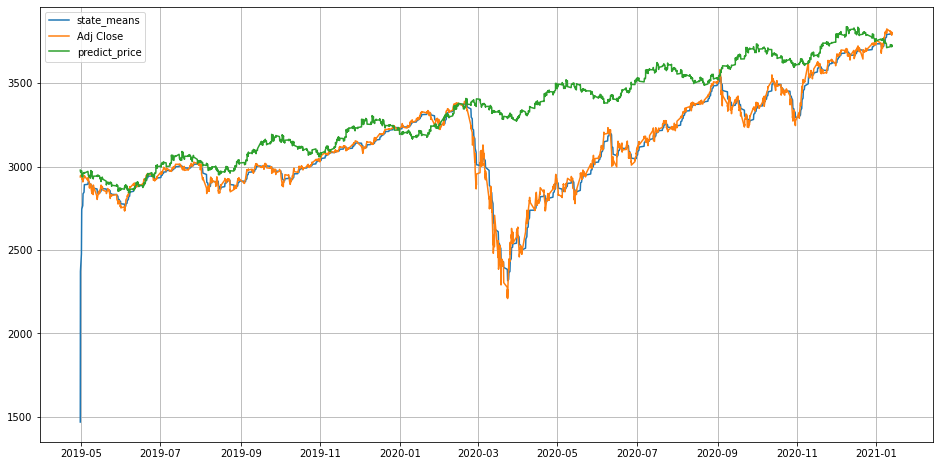

In [203]:
plt.figure(figsize=(16,8))
plt.plot(df['state_means'])
plt.plot(df['Adj Close'])
plt.plot(df['predict_price'])
plt.grid()
plt.legend(['state_means','Adj Close','predict_price'])